In [125]:
# Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import mobilenet_v2
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from sklearn.metrics.pairwise import cosine_similarity

In [126]:
dataset_dir = 'dataset'
images_dir = os.path.join(dataset_dir, 'images')
labels_csv = os.path.join(dataset_dir, 'labels.csv')

In [127]:
# Load the model if exists
model = None
if os.path.exists('model.keras'):
    model = tf.keras.models.load_model('model.keras')
    print("Model loaded successfully")

Model loaded successfully


In [128]:
from sklearn.preprocessing import MultiLabelBinarizer

def cnn_model(input_shape):
    base_model = mobilenet_v2.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False

    model = Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
    ])

    return model

def retrain_model(model, input_shape, classes):
    if model is None:
        model = cnn_model(input_shape)
    else:
        model.pop()

    model.add(layers.Dense(len(classes), activation='relu'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def train_model(model, train_data, train_labels, epochs):
    model.fit(train_data, train_labels, epochs=epochs)
    return model

def load_dataset(images_dir, labels_csv, input_shape):
    labels_df = pd.read_csv(labels_csv, sep=',')
    labels = labels_df.iloc[:, 1:].values
    images = []
    image_names = []

    for img_name in labels_df.iloc[:, 0]:
        img_path = os.path.join(images_dir, img_name)
        img = keras.preprocessing.image.load_img(img_path, target_size=input_shape)
        img_array = keras.preprocessing.image.img_to_array(img)
        images.append(img_array)
        image_names.append(img_name)

    images = np.array(images)
    
    labels = [label.split(';') for label in labels_df.iloc[:, 1]]
    classes = sorted(set([item for sublist in labels for item in sublist]))
    mlb = MultiLabelBinarizer(classes=classes)
    labels = mlb.fit_transform(labels)
    return images, labels, classes, image_names

In [129]:
# Load dataset
data, labels, classes, image_names = load_dataset(images_dir, labels_csv, (224,224))
input_shape = data.shape[1:3] + (3,)
data = data / 255.0
train_data, test_data, train_labels, test_labels, train_names, test_names = train_test_split(data, labels, image_names, test_size=0.2, random_state=42)
print(classes)

['apple', 'banana', 'blue', 'brown', 'cherry', 'chickoo', 'fruit', 'grape', 'green', 'kiwi', 'mango', 'orange', 'purple', 'red', 'strawberry', 'yellow']


In [130]:
# Retrain model or make a new one if missing
# model = None
model = retrain_model(model, input_shape, classes)
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │        16,400 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,586,128 (13.68 MB)

 Trainable params: 1,328,144 (5.07 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [131]:
augment_layer = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.1),
])
augmented_train_data = augment_layer(train_data)

In [132]:
from tensorflow.keras.callbacks import EarlyStopping

# Define training settings
train_settings = {
    'epochs': 30,
    'callbacks': [
        EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
    ],
    'validation_split': 0.2,
    'batch_size': 32
}

# Train the model with the settings
history = model.fit(augmented_train_data, train_labels, epochs=train_settings['epochs'], 
                callbacks=train_settings['callbacks'], 
                validation_split=train_settings['validation_split'], batch_size=train_settings['batch_size'])

Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 728ms/step - accuracy: 0.3514 - loss: 29.0792 - val_accuracy: 0.5357 - val_loss: 18.3356
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 593ms/step - accuracy: 0.4517 - loss: 16.4419 - val_accuracy: 0.5357 - val_loss: 12.4308
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 549ms/step - accuracy: 0.4326 - loss: 12.4837 - val_accuracy: 0.5357 - val_loss: 11.0761
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 587ms/step - accuracy: 0.3822 - loss: 10.7372 - val_accuracy: 0.5357 - val_loss: 10.8476
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 573ms/step - accuracy: 0.4500 - loss: 10.5064 - val_accuracy: 0.5357 - val_loss: 9.9637
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 571ms/step - accuracy: 0.4528 - loss: 9.2551 - val_accuracy: 0.5357 - val_loss: 9.7246
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 620ms/step - accuracy: 0.4229 - loss: 8.5864 - val_accuracy: 0.5357 - val_loss: 9.7258
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 617ms/step - accuracy: 0.4310 - loss: 8.6364 - val_accuracy: 0.5357 - 

In [133]:
# Save model
model.save('model.keras')
print("Model saved successfully")

Model saved successfully


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step - accuracy: 0.4025 - loss: 8.9141
Test accuracy:  0.41428571939468384
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 623ms/step


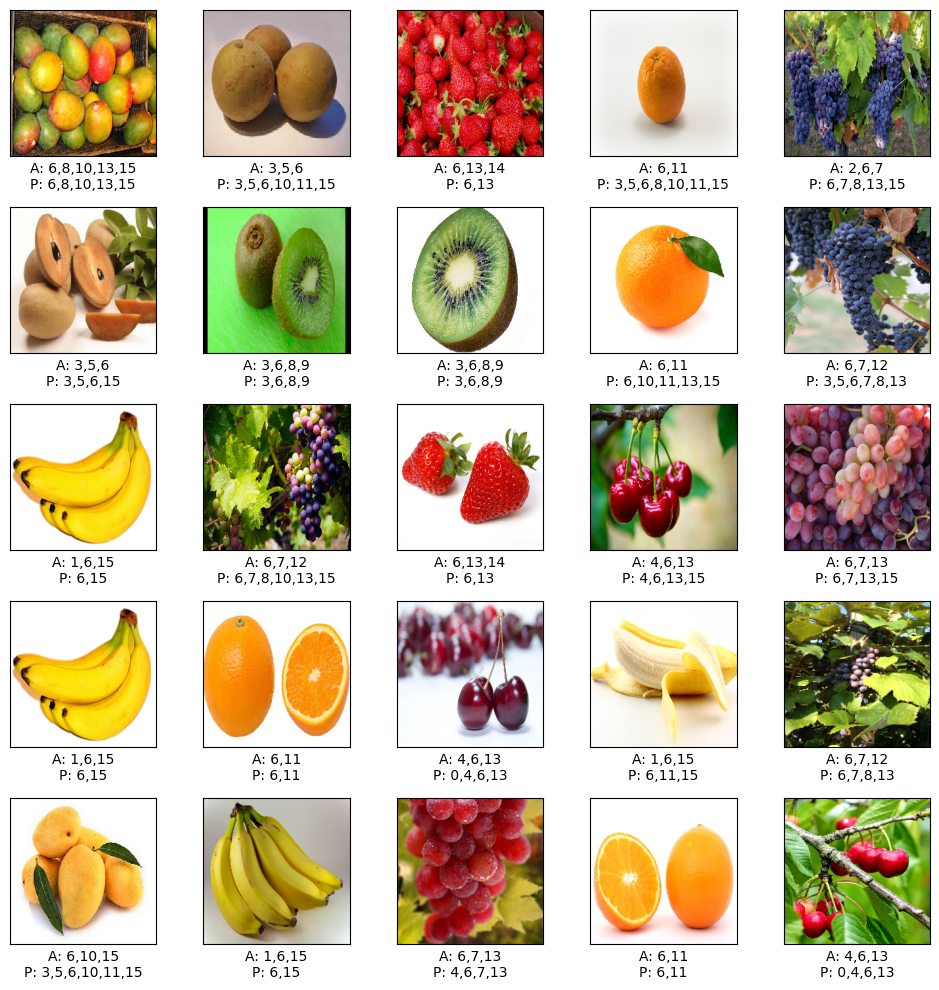

In [134]:
# Test model
test_loss, test_acc = model.evaluate(test_data, test_labels)
print("Test accuracy: ", test_acc)

# Predict
predictions = model.predict(test_data)
predicted_labels = np.argmax(predictions, axis=1)
predicted_labels = [classes[label] for label in predicted_labels]

# Plot
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.tight_layout()
    plt.imshow(test_data[i], cmap=plt.cm.binary)
    actual_labels = ','.join([str(idx) for idx, val in enumerate(test_labels[i]) if val == 1])
    predicted_labels_str = ','.join([str(idx) for idx, val in enumerate(predictions[i]) if val > 0.8])
    plt.xlabel(f"A: {actual_labels}\nP: {predicted_labels_str}")
plt.show()

In [ ]:
def extract_features(model, data):
    """
    Ekstraksi fitur dari gambar menggunakan model.
    """
    # feature_model = tf.keras.Model(inputs=model.input, outputs=model.output)  # ambil output terakhir
    features = model.predict(data)
    return features

def save_features(features, filename="features.npy"):
    """
    Menyimpan fitur gambar ke file .npy
    """
    np.save(filename, features)
    print(f"Features saved to {filename}")

def load_features(filename="features.npy"):
    """
    Memuat fitur gambar dari file .npy
    """
    return np.load(filename)

# Ekstraksi fitur untuk data latih
train_features = extract_features(model, train_data)

# Menyimpan fitur ke file .npy
save_features(train_features, 'features.npy')



9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 435ms/step
Features saved to features.npy


In [138]:
# Memuat fitur yang sudah disimpan
train_features = load_features('features.npy')


In [139]:
def search_by_image(query_image, model, train_data, train_labels, train_names, classes, top_n=5):
    query_feature = extract_features(model, np.expand_dims(query_image, axis=0))  # Ekstrak fitur dari gambar query
    train_features = load_features()  # Muat fitur-fitur dari gambar dalam dataset
    similarities = cosine_similarity(query_feature, train_features)  # Hitung kemiripan cosine

    # Mendapatkan indeks gambar dengan kemiripan tertinggi
    most_similar_idx = np.argsort(similarities[0])[::-1][:top_n]
    
    results = []
    for idx in most_similar_idx:
        img = train_data[idx]
        img_name = train_names[idx]  # Mendapatkan nama gambar
        similarity_score = similarities[0][idx]  # Mendapatkan nilai kemiripan
        labels = train_labels[idx]
        predicted_labels = [classes[label] for label in np.where(labels == 1)[0]]
        results.append((img_name, img, predicted_labels, similarity_score))  # Sertakan nama gambar dalam hasil
    
    return results


In [140]:
def search_by_label(query_labels, train_data, train_labels, classes, top_n=5):
    query_labels_bin = np.zeros_like(train_labels[0])
    for label in query_labels:
        label_idx = classes.index(label)
        query_labels_bin[label_idx] = 1
    
    # Menghitung kemiripan antara label query dengan label dalam dataset
    similarities = cosine_similarity([query_labels_bin], train_labels)
    
    # Mendapatkan indeks gambar dengan kemiripan tertinggi
    most_similar_idx = np.argsort(similarities[0])[::-1][:top_n]
    
    results = []
    for idx in most_similar_idx:
        img = train_data[idx]
        img_name = train_names[idx]  # Mendapatkan nama gambar
        similarity_score = similarities[0][idx]  # Mendapatkan nilai kemiripan
        labels = train_labels[idx]
        predicted_labels = [classes[label] for label in np.where(labels == 1)[0]]
        results.append((img_name, img, predicted_labels, similarity_score))
    
    return results

In [141]:
def plot_search_results(results):
    plt.figure(figsize=(10, 10))
    for i, (img_name, img, labels, similarity_score) in enumerate(results):
        plt.subplot(5, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.tight_layout()
        plt.imshow(img)
        plt.xlabel(f"Image: {img_name}\nLabels: {', '.join(labels)}\nSimilarity: {similarity_score:.4f}")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


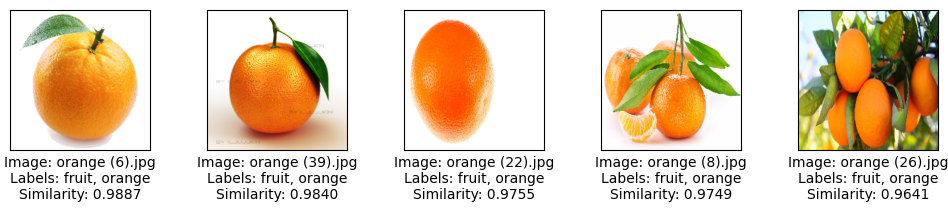

In [ ]:
# Test mencari gambar 
query_image = test_data[0]  # Gambar pertama dari data uji

# Pencarian gambar serupa
results = search_by_image(query_image, model, train_data, train_labels, train_names, classes)

plot_search_results(results)


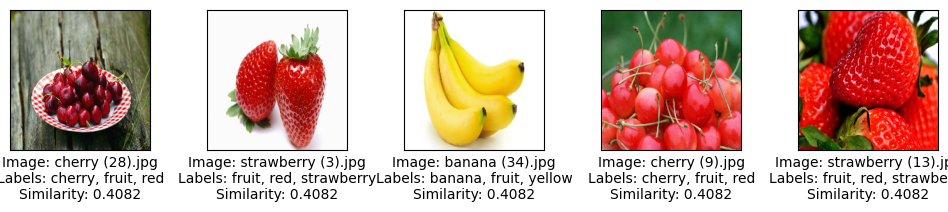

In [148]:
# Label yang ingin dicari
query_labels = ["banana", "red"]

# Pencarian berdasarkan label
results = search_by_label(query_labels, train_data, train_labels, classes)

# Tampilkan hasil pencarian
plot_search_results(results)
